## **Importing modules**

In [41]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.3 MB/s eta 0:00:00


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## **Select GPU**

In [18]:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device : {device}")

Using device : cuda


## **Loading Dataset**

In [19]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


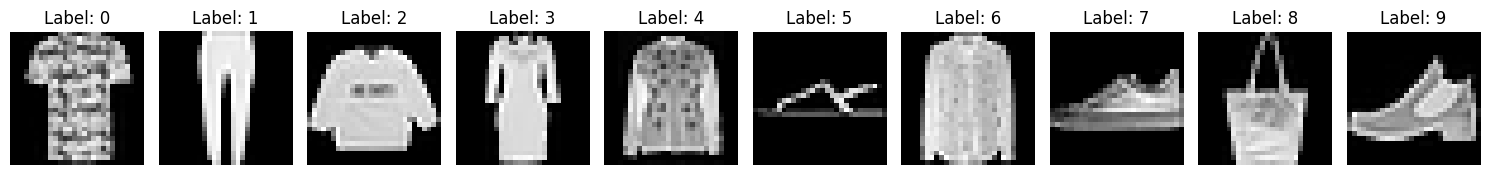

In [20]:
labels = sorted(df['label'].unique())  # [0,1,2,...,9]

fig, axes = plt.subplots(1,10, figsize=(15, 3))

for ax, label in zip(axes, labels):
    # pick one sample for each label
    sample = df[df['label'] == label].iloc[0]

    # reshape pixels to image
    img = sample[1:].values.reshape(28, 28)

    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {label}")

plt.tight_layout()
plt.show()

# **Train Test Split**

In [21]:
x = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)

In [23]:
#scaling features
x_train = x_train/255.0
x_test = x_test/255.0

## **Create Custom Dataset Class**

In [24]:
class CustomDataset(Dataset):
  def __init__(self,features,labels):
    self.features= torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [25]:
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)

In [26]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## **Training Pipeline**

**Define Model**

In [42]:
class MyModel(nn.Module):
  def __init__(self,num_of_features):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_of_features, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(64, 10)
    )

  def forward(self, x):
    return self.model(x)

**Parameters**

In [35]:
lr_rate = 0.01
epochs = 100

In [36]:
#initialize the model
model = MyModel(x_train.shape[1])
model.to(device)

#loss func
loss_func = nn.CrossEntropyLoss()

#optimizer
optimizer = optim.SGD(model.parameters(), lr=lr_rate, weight_decay=1e-5)

**Training**

In [37]:
for epoch in range(epochs):

  total_epoch_loss = 0
  for batch_features, batch_labels in train_loader:

    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    #forward pass
    y_pred = model(batch_features)

    #loss calculation
    loss = loss_func(y_pred, batch_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_epoch_loss += loss.item()

  loss = total_epoch_loss / len(train_loader)
  if epoch % 10 == 0:
    print(f"epoch : {epoch}, loss : {loss:.8f}")

epoch : 0, loss : 1.12776346
epoch : 10, loss : 0.43225446
epoch : 20, loss : 0.37093171
epoch : 30, loss : 0.33378428
epoch : 40, loss : 0.31214858
epoch : 50, loss : 0.28946569
epoch : 60, loss : 0.27291263
epoch : 70, loss : 0.25760202
epoch : 80, loss : 0.24478183
epoch : 90, loss : 0.23310891


**evaluation**

In [38]:
model.eval()

MyModel(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [39]:
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in test_loader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    outputs = model(batch_features)
    _, predicted = torch.max(outputs,1)

    total += batch_labels.shape[0]
    correct += (predicted == batch_labels).sum().item()

print(f"Accuracy : {correct/total:.8f}")

Accuracy : 0.88708333


## **Hyperparameter Tuning**

**define model**

In [44]:
class MyModel(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):
    super().__init__()
    layers = []

    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer
    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

In [45]:
# objective function
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyModel(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

  if optimizer_name == 'Adam':
    optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop
  for epoch in range(epochs):
    for batch_features, batch_labels in train_loader:
      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()

  # evaluation
  model.eval()

  # evaluation on test data
  total = 0
  correct = 0

  with torch.no_grad():
    for batch_features, batch_labels in test_loader:
      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
      outputs = model(batch_features)
      _, predicted = torch.max(outputs, 1)
      total = total + batch_labels.shape[0]
      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [46]:
import optuna

study = optuna.create_study(direction='maximize')

[I 2026-01-06 06:06:33,696] A new study created in memory with name: no-name-a93ae673-88a0-444c-b161-2c45cc783803


In [47]:
study.optimize(objective, n_trials=10)

[I 2026-01-06 06:07:43,269] Trial 0 finished with value: 0.8725833333333334 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 120, 'epochs': 10, 'learning_rate': 0.00011047609701475271, 'dropout_rate': 0.4, 'batch_size': 16, 'optimizer': 'Adam', 'weight_decay': 1.1729487576387482e-05}. Best is trial 0 with value: 0.8725833333333334.
[I 2026-01-06 06:11:41,264] Trial 1 finished with value: 0.8645833333333334 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 88, 'epochs': 30, 'learning_rate': 0.08404903256796141, 'dropout_rate': 0.5, 'batch_size': 16, 'optimizer': 'SGD', 'weight_decay': 0.00011273105161912204}. Best is trial 0 with value: 0.8725833333333334.
[I 2026-01-06 06:12:59,420] Trial 2 finished with value: 0.8810833333333333 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 120, 'epochs': 50, 'learning_rate': 0.00011698023544600378, 'dropout_rate': 0.2, 'batch_size': 64, 'optimizer': 'SGD', 'weight_decay': 1.3680763359385681e-05}. Best is trial

In [48]:
study.best_value

0.8810833333333333

In [49]:
study.best_params

{'num_hidden_layers': 1,
 'neurons_per_layer': 120,
 'epochs': 50,
 'learning_rate': 0.00011698023544600378,
 'dropout_rate': 0.2,
 'batch_size': 64,
 'optimizer': 'SGD',
 'weight_decay': 1.3680763359385681e-05}